# Contents Table 

1. Importing necessary packages 
2. Introducing and reformatting the data 
    1. 2.1 Loading and describing original dataset
    2. 2.2 Deriving age column
    3. 2.3 Combining material and design categories
    4. 2.4 Deriving condition variable
3. Exploratory analysis 
    1. 3.1 Variable distribution: predictors 
    2. 3.2 Variable distribution: condition 
    3. 3.3 Continuous predictor correlation
    4. 3.4 Continuous predictor and condition correlation
    5. 3.5 Categorical variable correlation
    6. 3.6 Categorical and condition correlation
    7. 3.7 Categorical and continuous predictor correlation
4. Regression 
    1. 4.1 Regression analysis 
    2. 4.2 Residual error distribution 
5. Conclusion
    1. 5.1 How well the proposed variables can predict the bridge condition?
    2. 5.2 Which of the proposed variables has more influence on the current condition?

# 1. Importing necessary packages

In [ ]:
# Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import scipy

%matplotlib inline

# 2. Introducing and reformatting the data

## 2.1. Loading and describing original dataset

In [ ]:
# Importing data
bridges = pd.read_csv("tx19_bridges_sample.csv")
# Dropping all missing values
bridges = bridges.dropna()

In [ ]:
# Specifying the columns I want to use
bridges_reduced = bridges[["Year", "AverageDaily", "Trucks_percent","Material","Design","Deck_rating","Superstr_rating","Substr_rating"]]

Below is an early version of the dataset which will be used in this report. It contains all the information which will be used, however, the data below will be transformed into a format which is more practical. Currently, there are eight columns. "Year" identifies the year in which the bridge was built, "AverageDaily" identifies the average amount of vehicles the bridge sees per day, "Trucks_percent" identifies how much of that traffic is made up of trucks, "Material" identifies whether a bridge is made from "concrete", "steel", "timber", "masonry", or other, whilst "Design" specifies which of the following categories the bridge falls under: "slab", "beam", "frame", "truss", "arch", "suspension", "movable", "tunnel", "culvert", "mixed" or "other". 

The last three columns rate the quality of the bridge in their specific functions. "Deck_rating" identifies the condition of the bridge's deck, the "Superstr_rating" identifies the condition of the bridges superstructure, and the "Substr_rating", rates the quality of the bridges substructure (foundations). All of these use the following rating, starting at the lowest through to the highest: "Failed", "Failing", "Critical", "Serious", "Poor", "Fair", "Satisfactory", "Good", "Very Good", "Excellent". If a rating is missing it is filled with "NA". 

In [ ]:
bridges_reduced

,Year,AverageDaily,Trucks_percent,Material,Design,Deck_rating,Superstr_rating,Substr_rating
0,2005,1,0.0,Concrete,Slab,Good,Very Good,Very Good
1,2005,1,0.0,Concrete,Slab,Good,Good,Very Good
2,2012,100,0.0,Concrete,Beam,Very Good,Very Good,Very Good
3,1950,80,0.0,Timber,Beam,Good,Good,Poor
4,2004,150,4.0,Concrete,Beam,Good,Very Good,Very Good
...,...,...,...,...,...,...,...,...
34288,1994,300,40.0,Concrete,Beam,Good,Good,Good
34289,2000,300,40.0,Concrete,Beam,Good,Good,Good
34290,1996,1200,25.0,Concrete,Beam,Good,Good,Good
34291,1991,300,15.0,Concrete,Beam,Good,Good,Satisfactory


## 2.2. Deriving age column

Below the age of the bridge is derived from the "year" variable, and is put into the "age_years" column. This makes the age of the bridge more readable, and easier to use in statistical analysis.

The age is derived by taking 2022 away from the year in which the bridge was built. 

The following code is excluding bridges which are over 100 years old. Due to their age they are likely to be of poor condition and were made through outdated methods. Due to this they are unlikely to be representative of the wider population, and therefore don't aid the data analysis and are being removed. 

In [ ]:
# Creating new column for the bridge age 
bridges_reduced = bridges_reduced.assign(age_years = 2022 - bridges_reduced["Year"])

In [ ]:
# Filtering out all bridges which are older than 100 years
bridges_reduced = bridges_reduced[bridges_reduced["age_years"] < 100]

Text(0.5, 1.0, 'Distribution of Bridge Ages')

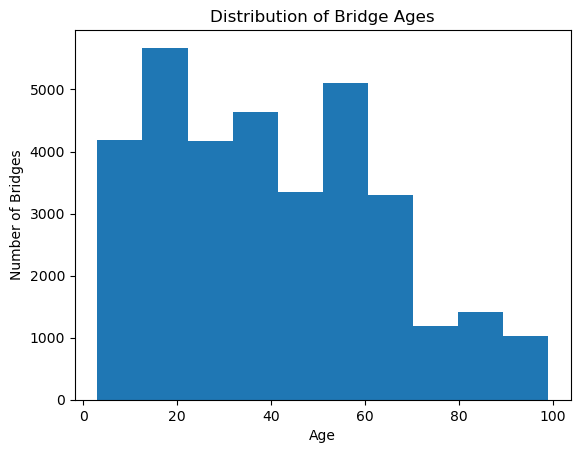

In [ ]:
# confirming there are no bridges older than 100 through a histogram
plt.hist(bridges_reduced["age_years"])
plt.xlabel("Age")
plt.ylabel("Number of Bridges")
plt.title("Distribution of Bridge Ages")

## 2.3 Combining material and design categories

The following code checks the amount of bridges which fall into every material category. Masonry only has 10 observations, which is a very small amount compared to over 30,000 bridges. Therefore, it makes sense to conflate it with the "other" section to improve the performance of the analysis and the readability of the dataset. 

In [ ]:
# Checking material counts
bridges_reduced["Material"].value_counts()

Concrete    26961
Steel        6562
Timber        465
Other          47
Masonry        10
Name: Material, dtype: int64

In [ ]:
# Placing Masonry into the Other category due to its small size
bridges_reduced = bridges_reduced.replace({"Masonry":"Other"})
bridges_reduced["Material"].value_counts()

Concrete    26961
Steel        6562
Timber        465
Other          57
Name: Material, dtype: int64

The below code is carrying out the same process, but for the design column. Here the "suspension", "movable", and "frame" categories are being put into the "other" category. 

In [ ]:
# Checking design counts 
bridges_reduced["Design"].value_counts()

Beam          28239
Slab           4251
Other          1238
Arch            136
Truss            95
Frame            68
Movable          13
Suspension        5
Name: Design, dtype: int64

In [ ]:
# Merging the Suspension, Movable, and Frame bridges due to their small size
bridges_reduced = bridges_reduced.replace({"Suspension":"Other", "Movable":"Other","Frame":"Other"})
bridges_reduced["Design"].value_counts()

Beam     28239
Slab      4251
Other     1324
Arch       136
Truss       95
Name: Design, dtype: int64

## 2.4 Deriving condition variable

A regression needs to act on a continuous numerical variable, meaning the conditions need to be transformed from categories into a single number. This is achieved by assigning each condition category such as "excellent" a number. Failed is given 0, with each category after gaining 1 point, until excellent, which has the number 9. 

All numbers are then added to produce an overall rating variable. For example, if a specific bridge had a "serious" rating (3) for its deck, a "poor" (4) rating for its superstructure, and a critical (2) rating for its substructure its overall condition rating would be the sum of those numbers (9). The possible condition rating range from 0 (0 in all condition ratings) to 27 (9 in all condition ratings).  

In [ ]:
bridges_reduced = bridges_reduced.replace({"Excellent":9, "Very Good":8, "Good":7, "Satisfactory":6, "Fair":5, "Poor":4, "Serious":3, "Critical":2, "Failing":1, "Failed":0})

In [ ]:
bridges_reduced = bridges_reduced.assign(condition = bridges_reduced["Deck_rating"] + bridges_reduced["Superstr_rating"] + bridges_reduced["Substr_rating"])

All the transformed variables are then stored in a new dataframe, called "bridges_final". This includes the original four columns from the initial dataset: "AverageDaily", "Trucks_percent", "Material", and "Design". It also contains the two derived variables: "age_years", and "condition". 

In [ ]:
bridges_final = bridges_reduced[["AverageDaily", "Trucks_percent", "Material","Design","age_years", "condition"]]
bridges_final = bridges_final.copy()
bridges_final.Material = bridges_final.Material.astype("category")
bridges_final.Design = bridges_final.Design.astype("category")

In [ ]:
bridges_final.dtypes

AverageDaily         int64
Trucks_percent     float64
Material          category
Design            category
age_years            int64
condition            int64
dtype: object

# 3. Exploratory analysis 

## 3.1 Variable distribution: predictors 

Below the distribution of the predictor variables is illustrated through the use of histograms. The histogram divides each variable into ranges. For example, for the "AverageDaily" the first range could go from 0 to 10, and all bridges with between 0 to 10 average daily uses would go into that range. The histograms below are divided into 10 bins meaning starting with the smallest value 10 ranges are created, ending with the largest value. 

If the distribution was normal its shape would be symmetrical with its peak in the center and the tails falling down, like an upside down bell. It is not necessary for this to be the case for a regression, however it could improve the quality of the regression results. 

Overall, none of the three predictor variables are normally distributed. "AverageDaily" is very positively skewed meaning it peaks to the left of the graph, and has a long tail to the right. This indicates the majority of the bridges experience little daily usage, whilst a small minority experiences a very high amount of usage. 

Text(0.5, 1.0, 'Distribution of Bridge Average Daily Use')

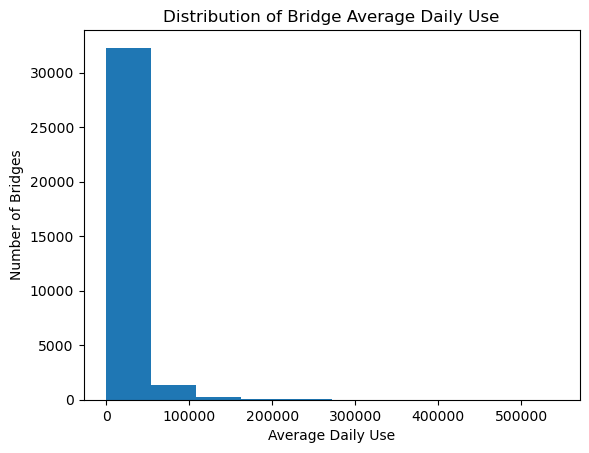

In [ ]:
plt.hist(bridges_final["AverageDaily"], bins = 10)
plt.xlabel("Average Daily Use")
plt.ylabel("Number of Bridges")
plt.title("Distribution of Bridge Average Daily Use")

"Trucks_percent" seems to have a similar distribution, though it is more distributed than average daily use.

Furthermore, the majority of bridges seem to fall into the category close to zero, indicating very little, if any, truck activity on those bridges. After that, most bridges fall under 25%, with a minority reaching just below 50%. This indicates a similar relationship to "Average_Daily", where most bridges experience a lower percentage of truck usage, with few experiencing a disproportionately high usage. 

This is also not a normal distribution. 

Text(0.5, 1.0, 'Distribution of Trucks Percentage')

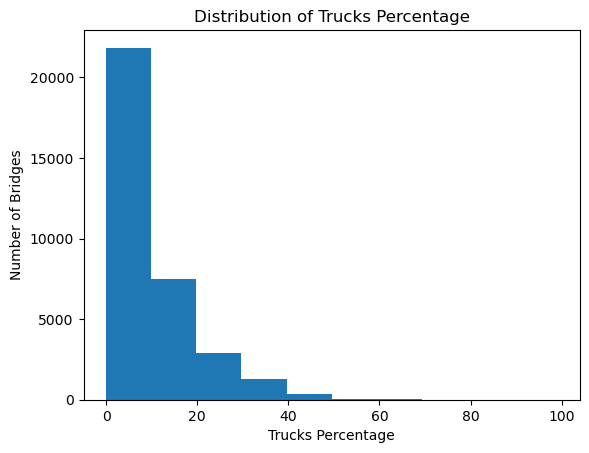

In [ ]:
plt.hist(bridges_final["Trucks_percent"], bins = 10)
plt.xlabel("Trucks Percentage")
plt.ylabel("Number of Bridges")
plt.title("Distribution of Trucks Percentage")

The distribution of ages is different to the previous two examples. The distribution peaks to the left, and has a noticeable negative skew (meaning it leans to the right). This distribution is less affected by outliers due to our removal of older bridges. This indicates most bridges are younger than 75 years old. The three distinctive peaks most likely indicate large production periods. 

This distribution is also not normal. 

Text(0.5, 1.0, 'Distribution of Bridge Age')

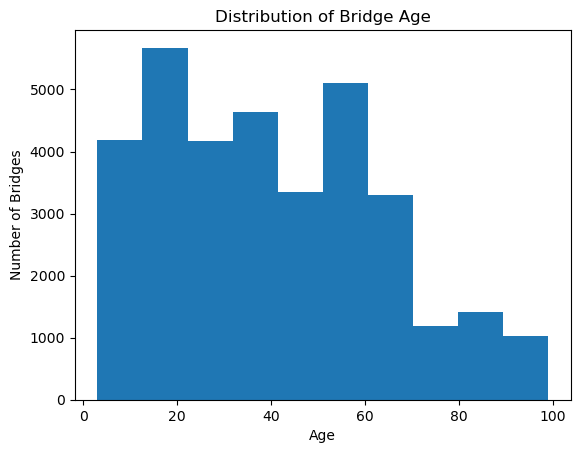

In [ ]:
plt.hist(bridges_final["age_years"], bins = 10)
plt.xlabel("Age")
plt.ylabel("Number of Bridges")
plt.title("Distribution of Bridge Age")

## 3.2 Variable distribution: condition 

Unlike the predictors, the dependent variable should be normally distributed to maximize the quality of the regression line fit. The condition variable is not normally distributed, as it peaks to the right with most bridges having a rating of 20. 

Text(0.5, 1.0, 'Distribution of Bridge Condition')

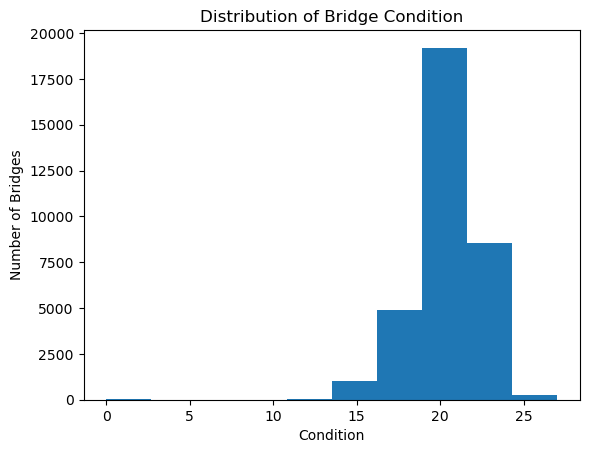

In [ ]:
plt.hist(bridges_final["condition"], bins = 10)
plt.xlabel("Condition")
plt.ylabel("Number of Bridges")
plt.title("Distribution of Bridge Condition")

## 3.3 Predictor correlations

The following section will explore whether the predictor variables are independent of each other. If they are not independent, this will undermine the interpretability of the regression results. 

Overall, the continuous predictors do not seem heavily correlated. The continuous variables include: "AverageDaily", "Age", and "Trucks_percent". Below are three scatter plots, and three correlation coefficients. If there was significant correlation the scatter plots would illustrate a cohesive relationship, where when one variable increases/decreases the other reacts in a predictable manner. This does not seem to be the case for the following data. 

The correlation coefficients quantify this relationship. A coefficient above 0 indicates a positive correlation, whilst one below 0 indicates a negative correlation. A positive correlation occurs when if one variable increases so does the other. A negative correlation occurs when if one variable increases the other decreases. A correlation coefficient ranges from -1 to 1. 

The correlation coefficients for "AverageDaily" and "Trucks_percent" and "AverageDaily" and "age_years" are both quite close to zero. "Trucks_percent" and "age_years" has a coefficient of 0.23, indicating a slight positive correlation, however, this is quite low and therefore most likely acceptable for a regression.

### Average daily and trucks percent correlation

0.02221808403036012


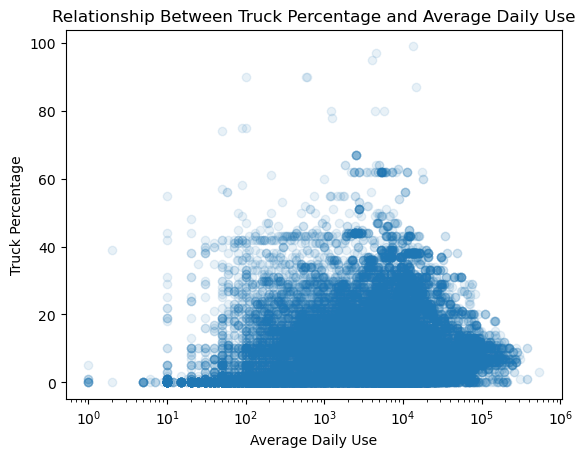

In [ ]:
plt.scatter(bridges_final["AverageDaily"], bridges_final["Trucks_percent"], alpha = 0.1)
plt.xscale("log")
plt.ylabel("Truck Percentage")
plt.xlabel("Average Daily Use")
plt.title("Relationship Between Truck Percentage and Average Daily Use")
print(bridges_final["AverageDaily"].corr(bridges_final["Trucks_percent"]))

### Average daily and age correlation 

-0.05277021885473681


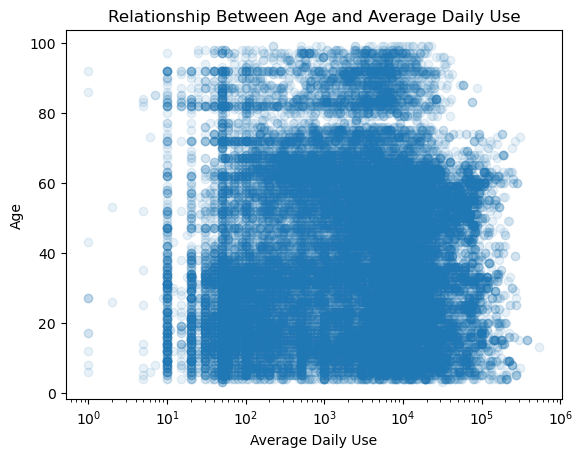

In [ ]:
plt.scatter(bridges_final["AverageDaily"], bridges_final["age_years"], alpha = 0.1)
plt.xscale("log")
plt.ylabel("Age")
plt.xlabel("Average Daily Use")
plt.title("Relationship Between Age and Average Daily Use")
print(bridges_final["AverageDaily"].corr(bridges_final["age_years"]))

### Truck percent and age correlation 

0.23008066057525509


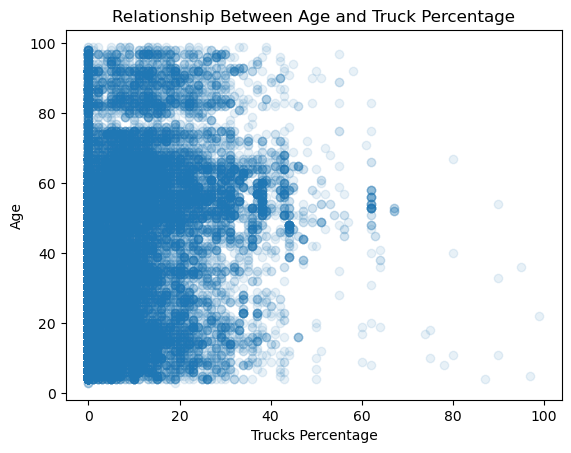

In [ ]:
plt.scatter(bridges_final["Trucks_percent"], bridges_final["age_years"], alpha = 0.1)
plt.ylabel("Age")
plt.xlabel("Trucks Percentage")
plt.title("Relationship Between Age and Truck Percentage")
print(bridges_final["Trucks_percent"].corr(bridges_final["age_years"]))

## 3.4 Predictor and condition correlation

This section looks at the correlations between the condition variable, and the predictor variables. Ideally, this would produce significant correlations, indicating a strong relationship between the predictors and the label value. However, it is possible to have a strong regression without strong correlations in situations when the predictors combine to provide good predictive value.

Age is strongly negatively correlated to condition, indicating that as the bridge becomes older its condition decreases. The correlation coefficients for "AverageDaily" and condition and "Trucks_percent" and condition are both very low, indicating a lack of correlation between those variables. This indicates the regression will show age has strong predictive power, compared to "AverageDaily" and "Trucks_percent". Furthermore, the regression will most likely show condition significantly decreases as age increases. 

### Condition and age

-0.5909015768609265


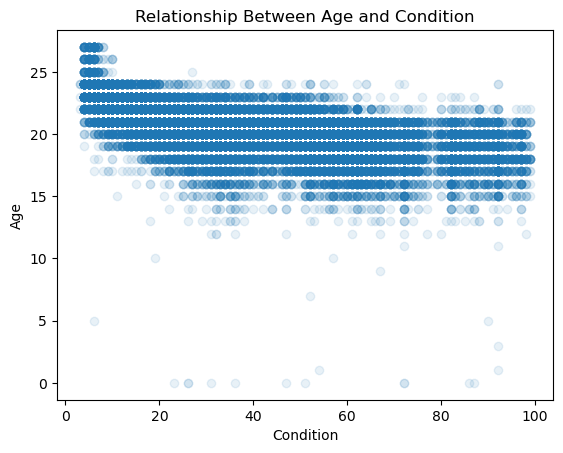

In [ ]:
plt.scatter(bridges_final["age_years"], bridges_final["condition"], alpha = 0.1)
plt.ylabel("Age")
plt.xlabel("Condition")
plt.title("Relationship Between Age and Condition")
print(bridges_final["age_years"].corr(bridges_final["condition"]))

### Condition and average daily 

0.034865398673657205


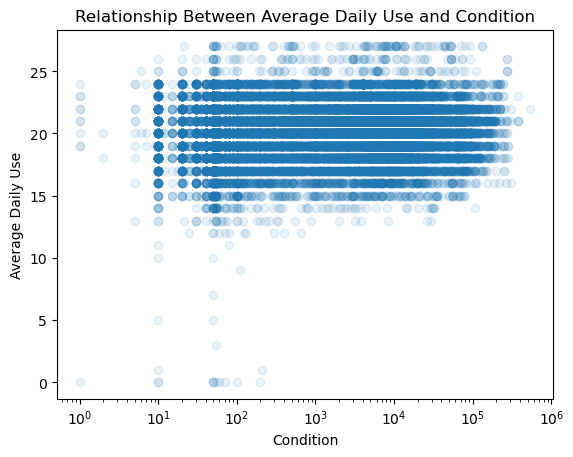

In [ ]:
plt.scatter(bridges_final["AverageDaily"], bridges_final["condition"], alpha = 0.1)
plt.xscale("log")
plt.ylabel("Average Daily Use")
plt.xlabel("Condition")
plt.title("Relationship Between Average Daily Use and Condition")
print(bridges_final["AverageDaily"].corr(bridges_final["condition"]))

### Condition and trucks percent 

-0.049303250849657095


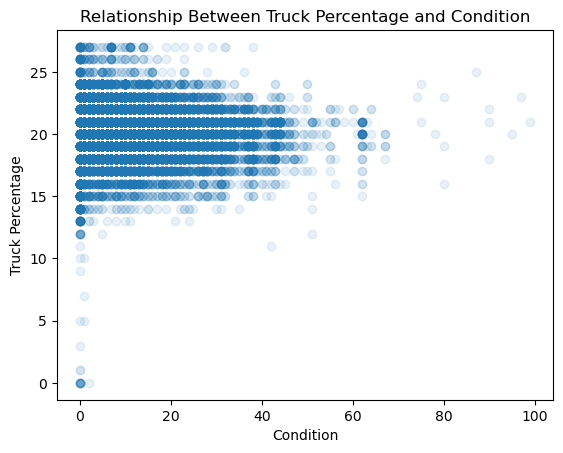

In [ ]:
plt.scatter(bridges_final["Trucks_percent"], bridges_final["condition"], alpha = 0.1)
plt.ylabel("Truck Percentage")
plt.xlabel("Condition")
plt.title("Relationship Between Truck Percentage and Condition")
print(bridges_final["Trucks_percent"].corr(bridges_final["condition"]))

## 3.5 Categorical variable correlation

The tables below show the relationship between the design of the bridge and the material used to build them.

The first table shows the amount of bridges which are in both categories. Therefore, 21,653 bridges are made out of concrete and have a beam design. Alternatively, 6122 bridges are made out of steel and have a beam design. 

In [ ]:
#sup_given_scour = pd.crosstab(bridges.Superstr_rating, [bridges.Scour_rating], normalize = "index")
bridges_final
material_design_cross = pd.crosstab(bridges_final.Material, [bridges_final.Design])
material_design_cross

Design,Arch,Beam,Other,Slab,Truss
Material,,,,,
Concrete,67,21653,990,4251,0
Other,16,0,41,0,0
Steel,53,6122,292,0,95
Timber,0,464,1,0,0


The table below shows the probability of each design given a specific material. For example, given a concrete bridge there is an 80% chance of the design being beam. On the other hand, if the material is "other" there is a 71% the design is also "other", and a 28% chance the design is arch. If the material is steel, there is a 93% chance the design is beam. Furthermore, 99% of timber bridges have a beam design. 

Overall, this implies the material and design categories are not independent of each other, as one heavily implies the other. 

In [ ]:
pd.crosstab(bridges_final.Material, [bridges_final.Design], normalize = "index")

Design,Arch,Beam,Other,Slab,Truss
Material,,,,,
Concrete,0.002485,0.803123,0.036720,0.157672,0.000000
Other,0.280702,0.000000,0.719298,0.000000,0.000000
Steel,0.008077,0.932947,0.044499,0.000000,0.014477
Timber,0.000000,0.997849,0.002151,0.000000,0.000000


The below table shows the probability of each material given a design. For example, if the design is arch there is a 49% chance the material will be concrete, an 11% chance it will be other and a 39% chance it will be steel. Alternatively, if the design is beam there is a 76% chance the material will be beam, and a 21% chance it will be steel. Furthermore, if the design is other there 74% the material will be concrete, and a 22% chance it will be steel. All slab bridges are concrete and all truss bridges are steel. 

In [ ]:
pd.crosstab(bridges_final.Material, [bridges_final.Design], normalize = "columns")

Design,Arch,Beam,Other,Slab,Truss
Material,,,,,
Concrete,0.492647,0.766776,0.747734,1.0,0.0
Other,0.117647,0.000000,0.030967,0.0,0.0
Steel,0.389706,0.216792,0.220544,0.0,1.0
Timber,0.000000,0.016431,0.000755,0.0,0.0


To conclude, the design and material of the bridges are not independent of each other. For all materials the beam design is the most common, other than the "other" material, where the "other" design is most common. Similarly, for the beam, slab and "other" designs concrete is most likely. For the arch design concrete and steel account for the vast majority. All truss bridges are steel. 

This implies collinearity between the design and material variables, which undermines the results of the regression. It does not affect the regression's predictive power, meaning if the task was to predict the condition of new bridges the collinearity would not undermine the model's performance. However, given the task is understanding the impact of various variables on the bridge's condition, this collinearity makes the model less reliable. 

## 3.6 Categorical and condition correlation

The next step is to assess the relationship between the categorical variables (material and design) and the condition of the bridge. To do this we will use boxplots. This section will initially explain the structure of a boxplot, before analyzing the specific boxplots below. 

A boxplot consists of 5 elements. The lowest line is the minimum, meaning the lowest value in said distribution. The second line from the bottom is the first quartile, meaning the point below which there is 25% of the data in a given distribution. The next is the median, meaning the middle value of the distribution, after which comes the 3rd quartile, which is the point below which 75% of the distribution exists. Finally, the top line is the maximum which is the highest value in the distribution. The boxplot also has circles above and below the minimum and maximum. These are what the boxplot identifies as outliers, meaning values which are extremely different to the rest of the distribution, and therefore could misrepresent the boxplot itself. Therefore, they are labeled outside the plot, to illustrate some extreme cases exist, however, they do not represent the majority of cases. 

### Condition across designs

The first set of boxplots map each bridge design according to their condition rating. The x-axis represents each design, whilst the y-axis represents the condition. We can see the mediums for the arch, beam and other designs are all quite close, hovering at just above a 20 condition rating. The slab rating median is lower at 20, and the truss design is lowest, hovering at just above 15. Whilst the maximum values for beam, other, and slab are high, either reaching or exceeding 25, their minimum values reach or exceed 15. On the other hand, whilst the maximum for arch does not reach 25, it is the only design which has a minimum above 15. This suggests that whilst arch bridges do not hit the extremes of a 25+ condition rating, they are more consistent in their rating than other designs. This is further emphasized by the outliers. Whilst arch bridges only have two outliers, which go as low as 15 on the condition rating scale, beam, other, slab, and truss designs have 10, 4, 7, and 3 outliers each, with the beam, slab and truss outliers reaching as low as 0 on the condition rating scale. 

Based on these boxplots, it can be assumed arch, beam and other bridges are associated with a high condition rating, however, this relationship may be more consistent across arch bridges compared to the other two designs. On the other hand, slab bridges would be slightly lower, whilst truss bridges would perform the worst. 

### Condition across materials

The second set of boxplots explore the relationship between each bridge material and the condition rating. Concrete and other bridges appear to perform similarly. Concrete bridges consistently achieved values below and above 16 and below 25. Bridges classified in the other category have a wider range with 15 as their minimum and over 25 as their maximum. On the other hand, steel and timber both perform worse, and having a medium below 20. Steel has a minimum of 15, whilst timber has a minimum just above 10. 

Based on these boxplots bridges made out of concrete and other materials are associated with higher condition ratings, whilst those made out of steel and timber are associated with worse condition ratings. 

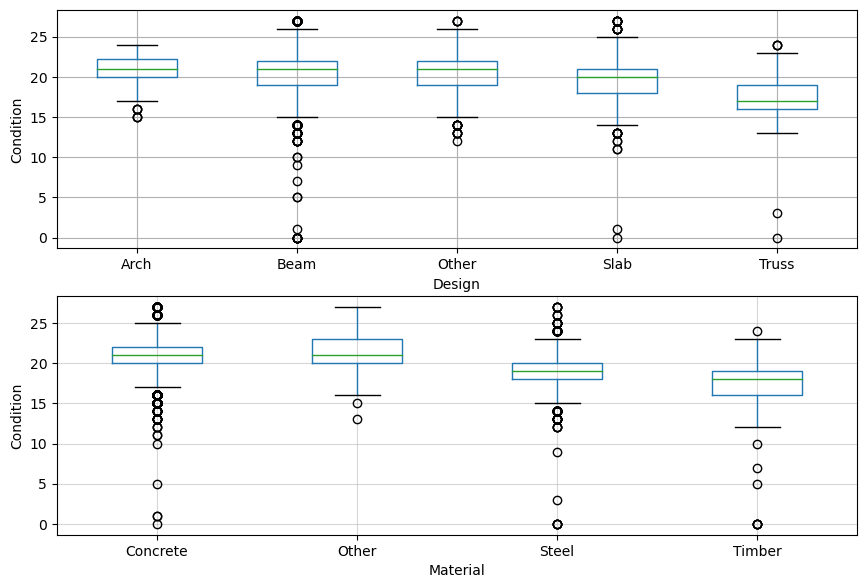

In [ ]:
fig, (a1, a2) = plt.subplots(2,1, figsize=(10, 7))

bridges_final.boxplot(column='condition', by='Design', ax=a1)
bridges_final.boxplot(column='condition', by='Material', ax=a2)

# Make the plots a bit clearer
fig.suptitle('')
[a.set_title('') for a in [a1, a2]]
a1.set_ylabel('Condition')
a2.set_ylabel('Condition')
plt.grid(alpha=0.5)

## 3.6 Categorical and continuous predictor correlation 

### Age and categorical variables comparison

The below analysis will assess whether the continuous variables (age, average_daily, and trucks_percent) and the categorical variables (material and design). 

The first set of boxplots illustrates the distribution of the bridge designs according to their age. Overall, it appears they are not independent of each other. Whilst "Arch", "Beam", and "Other" seem to have a similar age distribution with their medians falling below 20 and 40 years, "Slab" and "Truss" bridges have their medians at just over 60 and 80 years. This indicates that the design of a bridge and its age are somewhat correlated, however, this is only apparent for the "Slab" and "Truss" bridges. Again, this will make the regression coefficients somewhat less reliable due to collinearity. 

The second set of boxplots illustrates the distribution of bridge material according to their age. Here the relationship seems more independent. All medians fall between 20 and 40 years, with "Concrete", "Other", and "Steel" bridges ranging from 0 to 100 years. "Timber" bridges, break this pattern, as their maximal value reaches just over 60 years, with outliers reaching just below 100 years. Whilst this slightly breaks the pattern, material seems largely independent of age. 

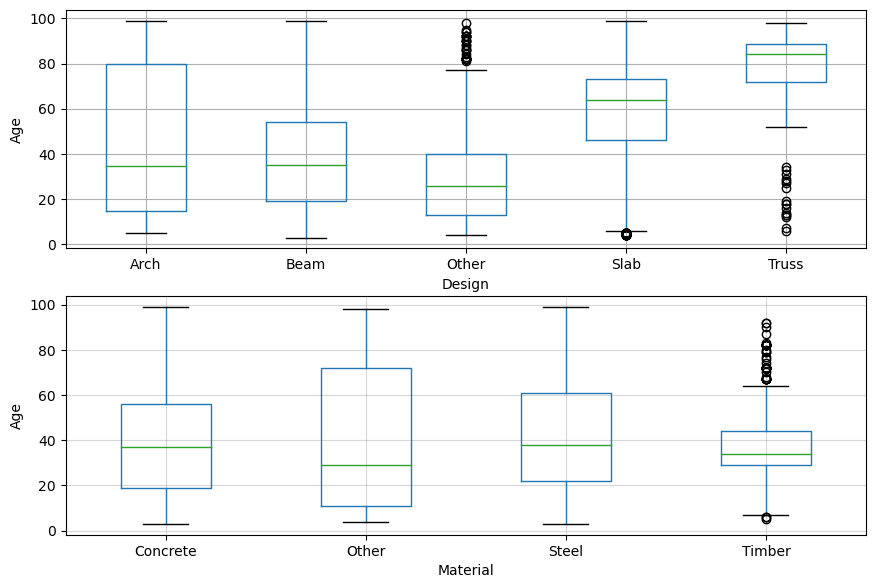

In [ ]:
fig, (a1, a2) = plt.subplots(2,1, figsize=(10, 7))

bridges_final.boxplot(column='age_years', by='Design', ax=a1)
bridges_final.boxplot(column='age_years', by='Material', ax=a2)

# Make the plots a bit clearer
fig.suptitle('')
[a.set_title('') for a in [a1, a2]]
a1.set_ylabel('Age')
a2.set_ylabel('Age')
plt.grid(alpha=0.5)

### Average daily and categorical comparison 

The third and fourth plots are generated without outliers as they make the plots less readable, and more difficult to interpret.  

The third boxplot assesses the relationship between bridge design and its average daily use. When looking at medians design seems largely independent of average daily use, as all medians fall below 5000 daily uses. However, this independence breaks down when one looks at the ranges and maximal values of each design. "Beam" bridges have a maximal value far higher than any other design. Similarly, "Slab" brigdges have a higher third quartlie and maximum than "Arch", "Other", and "Truss" bridges. Therefore, it appears average daily use and bridge design are not entirely independent, and somewhat correlated with each other. Again, this introduces the problem of collinearity, however, as the correlation doesn't appear to be strong the impact of this will be limited. 

The fourth set of boxplots looks at the relationship between average daily use and bridge material. Whilst the median value for all the bridges is under 5000, their ranges seem to be greatly varied. "Concrete" and "Steel" bridges have high maximum and third quartile values, whilst "Other" and "Timber" bridges have relatively low maximum and third quartile values. This implies, concrete and steel bridges have more bridges with a higher average daily use. As with the design, this implies average daily use and material are not entirely independent. 

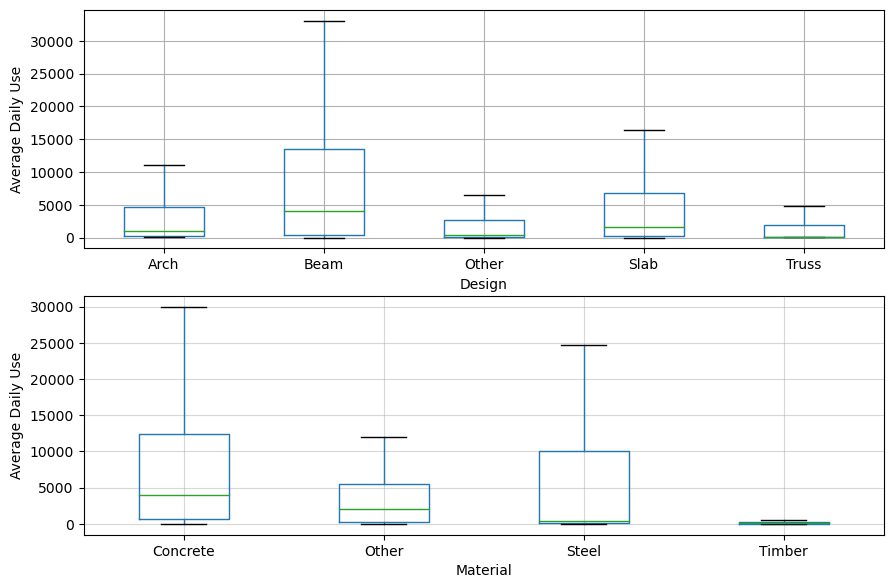

In [ ]:
fig, (a1, a2) = plt.subplots(2,1, figsize=(10, 7))

bridges_final.boxplot(column='AverageDaily', by='Design', ax=a1,showfliers=False)
bridges_final.boxplot(column='AverageDaily', by='Material', ax=a2,showfliers=False)

# Make the plots a bit clearer
fig.suptitle('')
[a.set_title('') for a in [a1, a2]]
a1.set_ylabel('Average Daily Use')
a2.set_ylabel('Average Daily Use')
plt.grid(alpha=0.5)

### Trucks percentage and categorical variables comparison 

The fifth set of boxplots assesses the relationship between the percentage of trucks and bridge design. "Beam" and "Slab" bridges have clearly higher medians than "Arch", "Other" and "Truss" bridges. In addition to this their third quartiles and maximal values are also significantly higher than the other three designs. This indicates, truck percentage and bridge design are not independent of each other.

The sixth set of boxplots assesses the relationship between the percentage of trucks and the bridge material. These variables also seem correlated. Concrete has a far higher median, third quartile and maximal value than any other material. Similarly, the third quartiles and maximal values for "Other" and "Steel" are significantly higher than the respective values for "Timber". Therefore, truck percentage and bridge material are not independent, and clearly correlated.   

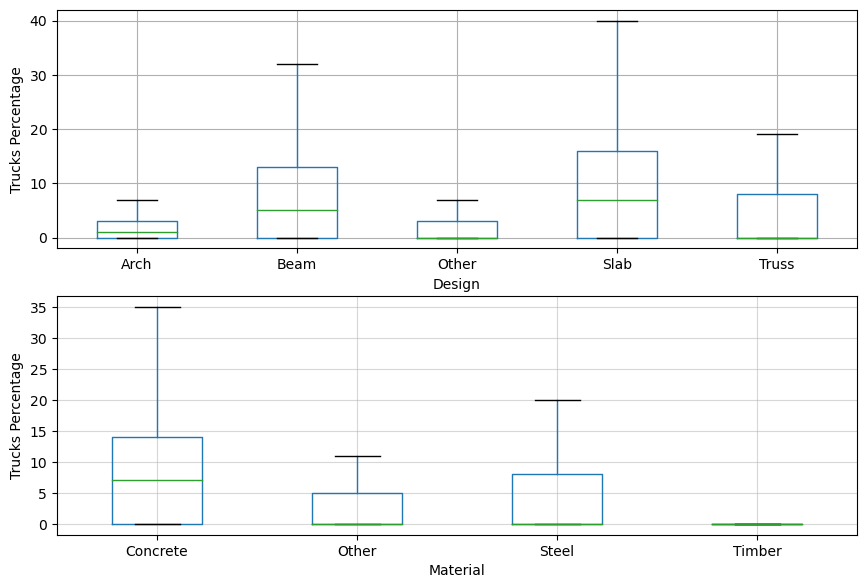

In [ ]:
fig, (a1, a2) = plt.subplots(2,1, figsize=(10, 7))

bridges_final.boxplot(column='Trucks_percent', by='Design', ax=a1,showfliers=False)
bridges_final.boxplot(column='Trucks_percent', by='Material', ax=a2,showfliers=False)

# Make the plots a bit clearer
fig.suptitle('')
[a.set_title('') for a in [a1, a2]]
a1.set_ylabel('Trucks Percentage')
a2.set_ylabel('Trucks Percentage')
plt.grid(alpha=0.5)

Overall, the past six sets of boxplots indicate the continuous variables and the categorical variables are not independent of each other. This indicates a degree of collinearity will impact the regression results, making the coefficients less reliable. This means our understanding of how each variable impacts the bridge condition will be undermined. 

In regards to the question about how well these variables predict bridge quality it seems they fail to predict bridge condition as their associates with the target variable are weak. Out of the continuous variables only age has a strong correlation with condition. When looking at the categorical variables variations exist, however, many of the design/material categories hover around similar condition averages with similar ranges. The predictive power of these variables in relation to bridge condition appears relatively low. 

As a preliminary answer to the question regarding which variable has the most influence on bridge condition it seems age has a strong influence on the condition of the bridge due to the high correlation between the age and condition variables. At the same time, it seems "concrete and other" bridges have higher condition scores, whilst "steel" and "timber" ones have lower condition scores. Furthermore, it seems the designs of the bridges have a generally similar effect on bridge condition, with the "Arch", "Beam", and "Other" designs appearing slightly better. 



# 4. Regression  

To assess how effectively these variables can predict bridge quality, and what their respective contribution to said quality is, we can use regression analysis. A linear regression will model the relationship between the predictor variables (age, average daily use, truck percentage, material and design) and the predicted variable (bridge quality). This model will return an R squared value, which will inform us on how well the predictor variables account for the variance of the predicted variables. This value will fall between 0 and 1. A higher value suggests the predictor variables we are working with do a good job of predicting bridge condition, and therefore we have identified most of the variables which account for bridge quality. A lower value suggests the predictor variables do not account for the whole picture, and other significant variables, which are not included in the regression, play an important part in the mechanism which is responsible for the bridge condition. 

A regression also produces coefficients. A coefficient indicates the way in which the predicted value (bridge condition) changes with each unit change of the predictor values. For example, for age the coefficient would tell us how much bridge condition changes with each extra year the bridge ages.

The below code carries out the regression analysis and presents the results in a clear and readable manner, which allows easy interpretation. 

In [ ]:
X = bridges_final[["AverageDaily","Trucks_percent","age_years","Material","Design"]]
y = bridges_final["condition"]
X = pd.get_dummies(data = X, drop_first = True)

In [ ]:
cols = ["AverageDaily","Trucks_percent","age_years","mat_other", "mat_steel","mat_timber","des_beam","des_other","des_slab","des_truss"]

In [ ]:
reg= linear_model.LinearRegression()
results = reg.fit(X,y)

In [ ]:
co = pd.DataFrame(reg.coef_).T
co.columns = cols
co              

,AverageDaily,Trucks_percent,age_years,mat_other,mat_steel,mat_timber,des_beam,des_other,des_slab,des_truss
0,-8.058609e-07,0.005157,-0.049275,-0.049952,-1.377669,-3.189717,-1.122751,-1.233182,-1.198366,-1.24939


In [ ]:
avg_coef, tp_coef, age_coef, mat_other_coef, steel_coef, timber_coef, beam_coef, des_other_coef, slab_coef, truss_coef = reg.coef_

In [ ]:
bridges_final.age_years.quantile(0.9), bridges_final.age_years.quantile(0.1)

(72.0, 11.0)

In [ ]:
avgd_range = bridges_final.AverageDaily.quantile(0.9) - bridges_final.AverageDaily.quantile(0.1)
trucks = bridges_final.Trucks_percent.quantile(0.9) -  bridges_final.Trucks_percent.quantile(0.1)
age = bridges_final.age_years.quantile(0.9) -  bridges_final.age_years.quantile(0.1)
conrange = bridges_final.condition.quantile(0.9) - bridges_final.condition.quantile(0.1)

In [ ]:
avgd_change = round((100 * (avg_coef * avgd_range) / conrange),2)
truck_change = round((100 * (tp_coef * trucks) / conrange),2)
age_change = round((100 * (age_coef * age) / conrange),2)

## 4.1 Regression Analysis

### R Squared

In [ ]:
print("This is the R Squared Value: " + str(reg.score(X, y)))

This is the R Squared Value: 0.45560225660456544


The R squared for this regression model is 0.46, rounded to 2 decimal places. This is relatively low, suggesting the predictors at hand do not effectively account for the variance in bridge condition. A way to address this would be to build a model with more predictor variables, utilizing more data and building a clearer picture of what mechanism exists behind bridge condition. 

### Age, average use, and trucks coefficients 

In [ ]:
print("This is the average daily coefficient: " + str(avg_coef))
print("This is the trucks percent coefficient: " + str(tp_coef))
print("This is the age coefficient: " + str(age_coef))

This is the average daily coefficient: -8.058609176013393e-07
This is the trucks percent coefficient: 0.005157307479762938
This is the age coefficient: -0.049275033004584814


When rounded down to two decimal places the coefficients for average daily use, truck percent, and age are 0.00, 0.01, and -0.05. However, these are problematic. Firstly, the average daily use coefficient is not actually 0, it is simply so small it is inconvenient to read when not rounded, but is rounded down to 0 if it is rounded. Furthermore, the truck and age coefficients are small and do not give an idea of the scale of the effect of both predictors. A way to address this is to see the effect of each predictor over their own respective range. If we were to take age as an example, we would take the 10th and 90th percentiles of age, meaning the value below which 10% of the age distribution exists and the value below which 90% of the age distribution exists. The 10th and 90th values are taken to avoid extreme values distorting the analysis. For age the 10th percentile is 11 years, whilst the 90th is 72. We will then take 72 away from 11 to get the range of the age distribution. We will then multiply this range by the age coefficient, and divide the result by the range of the condition rating. Finally, to produce a percentage we will multiply by 100. This shows how much the condition will change between a bridge which is 11 years old and one which is 72 years old. 

In [ ]:
print("Average daily percentage change over its range: " + str(avgd_change) + "%")
print("Trucks percentage change over its range: " + str(truck_change) + "%")
print("Age percentage change over its range: " + str(age_change) + "%")

Average daily percentage change over its range: -0.48%
Trucks percentage change over its range: 2.37%
Age percentage change over its range: -60.12%


The above code shows the percentage change of the three continuous variables over the course of their ranges. Between its 10th and 90th percentile the condition of the bridge decreases by 0.48%. For truck percentage the condition of the bridge increases by 2.37%. When looking at age, the condition of a bridge decreases by 60.12% across the age range. 

This indicates higher average daily use of a bridge slightly decreases its condition, whilst a higher proportion of trucks results in a slight increase in condition. It is important to note this does not indicate the trucks themselves improve the condition of the bridge. Higher truck percentage is simple associated with higher bridge condition, and this could be due to a third variable which is associated with them both. For example, when constructing the bridges the Texas authorities knew this bridge would be central for commercial transports, which include trucks, and therefore built it using more lasting and stronger materials. 

On the other hand, the effect of age on bridges in significant, and far higher than the other two continuous predictors. 

### Material and design coefficients 

As the material and design variables are not continuous they need to be interpreted in a different way to the continuous variables. Firstly, the categorical variables were converted into "dummy variables". This means each category in a variable is turned into its own category. Therefore, for design the single variable "Material" was turned into four variables: "Concrete", "Other", "Steel", and "Timber". If a bridge was made out of concrete the "Concrete" variable value would be a 1 for that bridge, and a 0 for every other material variable associated with that specific bridge. This would then be true for every other dummy variable. This turns non-numerical variables into numerical ones, meaning they can be used in a regression.

Secondly, during the regression process we dropped one of the categories for each variable. For design this was "Arch", whilst for material it was "Concrete". When interpreting the coefficients for the other categorical variables the dropped variables would act as references. For example, when looking at the coefficient for steel bridges if this coefficient was -1 that means if one were to switch from a concrete bridge to a steel one the resultant affect on the bridge condition would be -1. The categorical variables do not operate on the same basis as the continuous ones as they do not have a range. They simply exist, or do not. A bridge is either made out of steel or it is not.

#### Material

That being said, it is now possible to interpret the coefficients for the materials. 

In [ ]:
print("This is the other material coefficient: " + str(mat_other_coef))
print("This is the steel coefficient: " + str(steel_coef))
print("This is the timber coefficient: " + str(timber_coef))

This is the other material coefficient: -0.049951604588048544
This is the steel coefficient: -1.3776685932221864
This is the timber coefficient: -3.1897167277294525


The above coefficients suggest all materials would result in a decrease in condition when making the switch from concrete. The "other" material group has the smallest magnitude, being only -0.05, when rounding to two decimal places. The steel coefficient is higher, suggesting the switch from concrete to steel would result in a decrease in condition by 1.38. The decrease when switching from concrete to timber would be even greater, with a 3.2 decrease in condition. 

This is consistent with the previous boxplot analysis, which visually indicated the "other" material was similar to concrete, whilst the steel and timber materials were lower in terms of condition, with timber being lower than steel. Therefore, this analysis indicates if one was to optimize for bridge condition concrete would be the optimal material. 

#### Design

In the same manner we can analyze the design coefficients. 

In [ ]:
print("This is the beam coefficient: " + str(beam_coef))
print("This is the design other coefficient: " + str(des_other_coef))
print("This is the slab coefficient: " + str(slab_coef))
print("This is the truss coefficient: " + str(truss_coef))

This is the beam coefficient: -1.1227506852372542
This is the design other coefficient: -1.2331818761351998
This is the slab coefficient: -1.1983662216975808
This is the truss coefficient: -1.2493897734806862


The above coefficients suggest all designs would result in a decrease in bridge condition when making the switch from the "Arch design". All coefficients seem to be fairly similar, and fall within the -1.12 to -1.25 range, indicating their drop in quality when switching from the "Arch" design is fairly consistent across the other designs. Out of these the "Truss" coefficient is the highest, which aligns itself with the previous boxplot analysis as the "Truss" design had the lowest average condition rating. Otherwise, the general uniformity between the rest of the designs is consistent with the boxplot analysis, as generally the condition rating remained consistent across the designs. 

## 4.2 Residual error distribution 

A useful method to assess the performance of the model is to look at the distribution of its residual error. Below a normal distribution is illustrated. The x-axis represents a range of numbers, whilst the y-axis represents the probability of a number in that range occurring. The mean average value is 0, meaning it has the highest probability of occurring, and both sides are symmetrical. This is desirable in a distribution of errors as it means 0 would be the average, meaning the model has a tendency to produce predictions with a low error. Furthermore, as both sides are symmetrical the model doesn't have a tendency to either under predict or over predict. Therefore, it is useful to examine whether the distribution of errors from the model is normal.  

(array([0.00063176, 0.00600176, 0.03601054, 0.15857273, 0.31809311,
        0.37305657, 0.25302143, 0.09476458, 0.02179585, 0.00157941]),
 array([-4.19257849, -3.40114355, -2.60970862, -1.81827368, -1.02683874,
        -0.2354038 ,  0.55603113,  1.34746607,  2.13890101,  2.93033595,
         3.72177088]),
 <BarContainer object of 10 artists>)

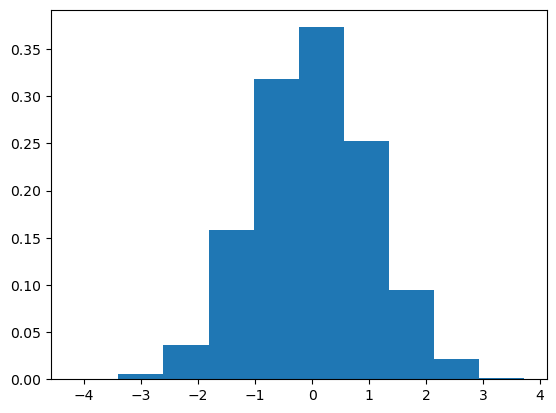

In [ ]:
normal = np.random.normal(0, 1, 4000)
plt.hist(normal, bins = 10, density = True)

Below is the distribution of errors for the regression. Whilst it may look roughly normal it is not. The distribution has a positive skew, meaning instead of being symmetrical its mean is to the left, and values to the right of the mean are higher than those to the left.

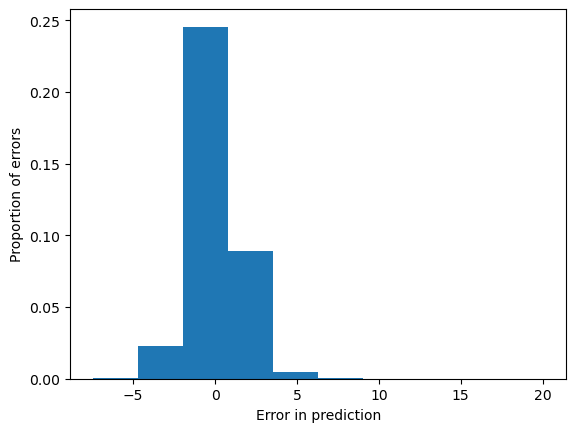

In [ ]:
y_hat = reg.predict(X)

fig, a1 = plt.subplots(1, 1)
residuals = y_hat - y
a1.hist(residuals, bins=10, density = True)
_ = a1.set_xlabel('Error in prediction')
_ = a1.set_ylabel('Proportion of errors')

The fact the distribution is positively-skewed is easier to visualize when the y-axis is re-scaled. A significant proportions of errors fall between -5 and 5, meaning the y-axis scale is automatically adjusted to visualize them best. However, this means we don't get a good visualization of values lower than -5 or higher than 5. This can be adjusted if we use a log of the y-axis. This means the scale of the histogram y-axis will vary. For example, the top point in the new histogram is 10 to the power of -1, which means 0.1. The next point is 10 to the power of -2 which is 0.01. This goes on until 10 to the power of -5 which is 0.00001. Therefore the lowest two points on the new histogram show the probability of an error between 0.00001 and 0.0001. 

On the new histogram errors go up to 20, meaning for those bridges their predicted condition was 20 over their actual condition. This is quite significant, considering the maximum possible condition is 27. Therefore, this shows us that our model occasionally drastically overestimates the condition of a bridge. 

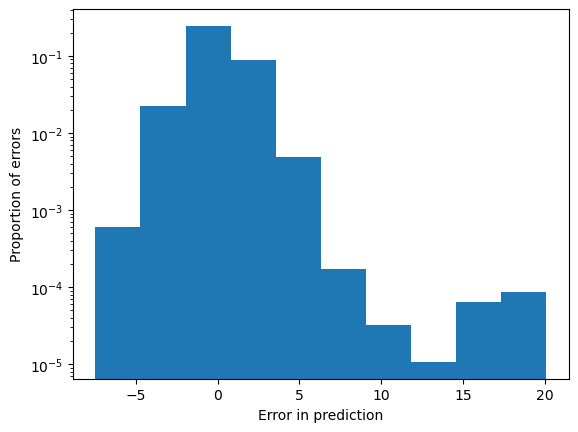

In [ ]:
y_hat = reg.predict(X)

fig, a1 = plt.subplots(1, 1)
residuals = y_hat - y
a1.hist(residuals, bins=10, density = True)
_ = a1.set_xlabel('Error in prediction')
_ = a1.set_ylabel('Proportion of errors')
_ = a1.set_yscale("log")

In [ ]:
def check(residuals):
    residuals_list = residuals.to_list()
    high = []
    for i in residuals_list:
        if i >= 10:
            high.append(i)
    return high 

over_10 = len(check(residuals))
print("This is the number of bridges which were misclassified by 10 or more: " + str(over_10))

This is the number of bridges which were misclassified by 10 or more: 16


However, when looking at the raw numbers the amount of bridges incorrectly classified by such a large margin is relatively low at 16, compared to over 34,000 bridges which were classified. Whilst the model could perform better, its tendency to drastically over-predict only affects a small number of bridges. 

# 5. Conclusion 

## 5.1 How well do the proposed variables predict the bridge condition?

The variables at hand are not enough to build an accurate model which can predict bridge condition. A relatively low R squared score of 0.46 indicates the chosen variables do not account for the variance in bridge condition, meaning more information needs to be added to the model. Furthermore, according to the distribution of residuals the model has a tendency to over-predict a bridge's quality, as the distribution of residuals is not normal and positively skewed. This further reinforces the point that the chosen variables do not account for the entirety of the variance in the condition variable. 


## 5.2 Which of the proposed variables has more influence on the current condition?

The variables vary in their respective predictive power. Whilst age accounts for significant shifts in the condition rating, this is not true for average daily use and truck percentage. The coefficients for the categorical variables indicate concrete and arch bridges have the highest condition ratings, with other materials and designs resulting in a decrease in condition. It is difficult to compare the variables in their influence on the condition due to their differing units and variable types. The unit problem was solved by estimating the amount condition changes over the range of a continuous variable, however, this does not apply to the categorical variables, making direct comparison difficult. If all variables were continuous a comparison would be simple as this would simply result in a comparison of coefficients. This would show the magnitude of change per unit of said variable, allowing us to compare the influence of the variables directly. This has been done with the continuous variables, and age was shown to be the most influential variable. Because the categorical variables do not operate on the same logic of units, this analysis does not extend to them. 

However, by looking at the largest shift in condition due to the change in material/design this can be compared to the change in the condition of a continuous variable. For example, the highest coefficient for any of the categorical variables is -3.2 for timber, indicating if the material was to be switched from concrete to timber the condition would decrease by 3.2 points. If the age of a bridge would change from the 10th percentile of age to the 90th percentile this would signify a 60.12% decrease in that bridge's quality. If the bridge quality was at 27 points before the drop, this would result in a decrease of 16.524 points in the condition rating. This indicates age has the most influence on the condition of the bridge. Though, this does not offer a perfect comparison as the the continuous variable shifts the condition based on units. Therefore, a single unit (year) would result in a smaller change in condition than the shift from concrete to timber. 

Overall, it makes more sense to compare the magnitude of effect between the continuous variables, the material categories and the design categories individually. As previously said the age variable seems to be the most influential among the continuous variable. The shift from concrete to timber is the largest for the material, indicating timber bridges result in the lowest condition ratings out of the materials. For design, Truss bridges result in the most significant shift at -1.25, meaning if the design were to switch from "Arch" to "Truss" the condition would decrease by -1.25. 

However, the reliability of these coefficients should be taken with a grain of salt due to the significant collinearity between the predictors. There is a strong correlation between the design and material variables. Furthermore, there are apparent correlations between the design/material variables and the age, average daily use, and truck percentage, though these vary in strength across the different combinations of variables. This strong collinearity makes it difficult to unpack which variables are having the most impact, and makes the coefficients unreliable. Future analysis would seek to include other variables.